In [189]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_docs.plots
import tensorflow_docs.modeling
import tensorflow_docs as tfdocs

from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Dropout, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Import & Preparation

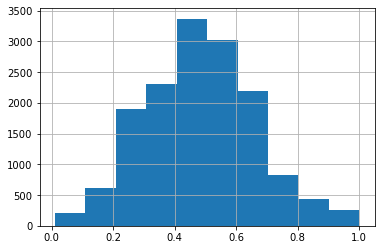

In [190]:
df = pd.read_csv('data.csv').drop_duplicates()
df = df.drop(['raw', 'meditation'], axis=1)
df.attention = df.attention / 100

df.attention.hist()

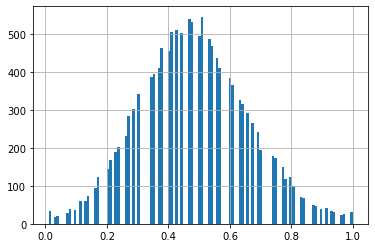

In [191]:
def remove_unchanged_row(df):
    selected = [0]
    for i in range(1, len(df)):
        if df.attention[i] != df.attention[i - 1]:
            selected += [i]
    return df.loc[selected]

def remove_outliers(df):
    out = pd.DataFrame()
    for att in df.attention.unique():
        tmp_df = df[df.attention == att]
        tmp = []
        for col in tmp_df.columns[1:]:
            Q1 = tmp_df[col].quantile(0.25)
            Q3 = tmp_df[col].quantile(0.75)
            tmp += [(col, Q1, Q3)]
        for col, Q1, Q3 in tmp:
            IQR = Q3 - Q1
            tmp_df = tmp_df[(tmp_df[col] >= Q1 - 1.5 * IQR) & (tmp_df[col] <= Q3 + 1.5 * IQR)]
        out = pd.concat([out, tmp_df])
    return out

def augment_data(df, size=4, scale=0.001):
    out = df.copy()
    columns = df.columns[1:]
    for _ in range(size - 1):
        tmp_df = df.copy()
        tmp_df[columns] = np.random.normal(tmp_df[columns], tmp_df[columns] * scale)
        out = pd.concat([out, tmp_df])
    return out

def add_log(df):
    for col in df.columns[1:]:
        df[f'log2-{col}'] = np.log2(df[col])
    df[f'log2-theta-alpha'] = np.log2(df['theta'] + df['low-alpha'] + df['high-alpha'])
    return df

def add_past_attention_values(df, n=-1):
    for i in range(-n):
        df[f'attention-{i+1}'] = df.attention.shift(i+1)
    return df.iloc[-n:]

def prepare_data(df):
    df = remove_unchanged_row(df)
    # df = df.drop_duplicates()
    # df = remove_outliers(df)
    # df = augment_data(df)
    df = add_past_attention_values(df, -5)
    df = df.sample(frac=1).reset_index(drop=True)
    df = df.groupby(df.attention).head(600)
    df = add_log(df)
    return df

df = prepare_data(df)
df.attention.hist(bins=df.attention.nunique() * 2)

In [192]:
def train_val_test_split(df, val_size=0.16, test_size=0.2):
    n = len(df)
    df = df.sample(frac=1).reset_index(drop=True)
    scaler = MinMaxScaler()
    scaler.fit(df.iloc[:, 1:])

    val = df.groupby('attention').apply(lambda x: x.head(int(len(x) * val_size))).reset_index(drop=True)
    test = df.groupby('attention').apply(lambda x: x.tail(int(len(x) * test_size))).reset_index(drop=True)
    train = pd.concat([df, val, test]).drop_duplicates(keep=False)

    X_train, y_train = train.iloc[:, 1:], train.iloc[:, :1]
    X_val, y_val = val.iloc[:, 1:], val.iloc[:, :1]
    X_test, y_test = test.iloc[:, 1:], test.iloc[:, :1]
    
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((8800, 27), (2159, 27), (2704, 27), (8800, 1), (2159, 1), (2704, 1))

## Model

In [193]:
def build_model():
    clear_session()
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    # model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(1e-2)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 665
Trainable params: 665
Non-trainable params: 0
_________________________________________________________________


In [194]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=0)
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), batch_size=32, callbacks=[es, reduce_lr], verbose=2)
model.save('model')

Epoch 1/1000
275/275 - 0s - loss: 0.0111 - mae: 0.0783 - mse: 0.0111 - val_loss: 0.0043 - val_mae: 0.0520 - val_mse: 0.0043 - lr: 0.0100
Epoch 2/1000
275/275 - 0s - loss: 0.0049 - mae: 0.0547 - mse: 0.0049 - val_loss: 0.0040 - val_mae: 0.0495 - val_mse: 0.0040 - lr: 0.0100
Epoch 3/1000
275/275 - 0s - loss: 0.0043 - mae: 0.0514 - mse: 0.0043 - val_loss: 0.0040 - val_mae: 0.0495 - val_mse: 0.0040 - lr: 0.0100
Epoch 4/1000
275/275 - 0s - loss: 0.0042 - mae: 0.0510 - mse: 0.0042 - val_loss: 0.0038 - val_mae: 0.0489 - val_mse: 0.0038 - lr: 0.0100
Epoch 5/1000
275/275 - 0s - loss: 0.0042 - mae: 0.0507 - mse: 0.0042 - val_loss: 0.0056 - val_mae: 0.0600 - val_mse: 0.0056 - lr: 0.0100
Epoch 6/1000
275/275 - 0s - loss: 0.0040 - mae: 0.0496 - mse: 0.0040 - val_loss: 0.0034 - val_mae: 0.0459 - val_mse: 0.0034 - lr: 0.0100
Epoch 7/1000
275/275 - 0s - loss: 0.0042 - mae: 0.0504 - mse: 0.0042 - val_loss: 0.0071 - val_mae: 0.0711 - val_mse: 0.0071 - lr: 0.0100
Epoch 8/1000
275/275 - 0s - loss: 0.0040 

Text(0, 0.5, 'Loss (MAE)')

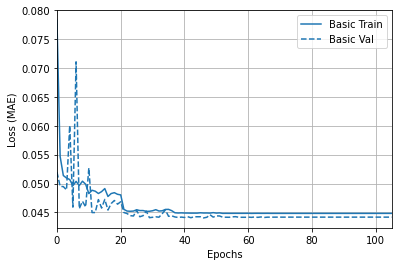

In [195]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=0)

plotter.plot({'Basic': history}, metric="mae")
plt.ylabel('Loss (MAE)')

## Prediction

In [196]:
# model = load_model('model')
loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)

85/85 - 0s - loss: 0.0033 - mae: 0.0454 - mse: 0.0033


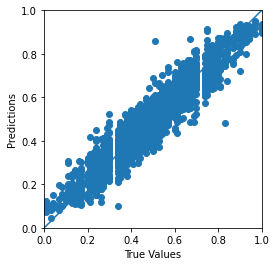

In [197]:
def compare_values(y_true, y_pred):
    a = plt.axes(aspect='equal')
    plt.scatter(y_true, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    lims = [0, 1]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    
y_pred = model.predict(X_test).flatten()
compare_values(y_test, y_pred)

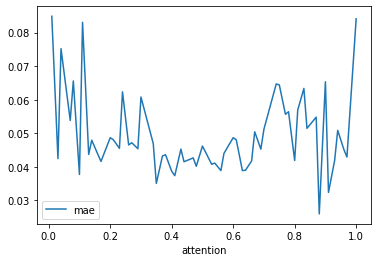

In [198]:
def plot_error_vs_attention(y_true, y_pred):
    df = pd.concat([pd.DataFrame(y_true, columns=['attention']), pd.DataFrame(y_pred, columns=['prediction'])], axis=1)
    d = {'attention': [], 'mae': []}
    for att in df.attention.unique():
        tem_df = df[df.attention == att]
        mae = mean_absolute_error(tem_df.attention, tem_df.prediction)
        d['attention'] += [att]
        d['mae'] += [mae]
    pd.DataFrame(d).set_index('attention').plot()

plot_error_vs_attention(y_test, y_pred)

# Regressors

In [199]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures


def plot_features_weights(model, weights, feature_names, weights_type='c'):
    (px, py) = (8, 10) if len(weights) > 30 else (8, 5)
    W = pd.DataFrame({'Weights':weights}, feature_names)
    W.sort_values(by='Weights', ascending=True).plot(kind='barh', color='r', figsize=(px,py))
    label = ' Coefficients' if weights_type =='c' else ' Features Importance'
    plt.xlabel(model + label)
    plt.gca().legend_ = None

X_train = np.concatenate([X_train, X_val])
y_train = np.concatenate([y_train, y_val])

0.04470815063411954
0.0032530775812875503


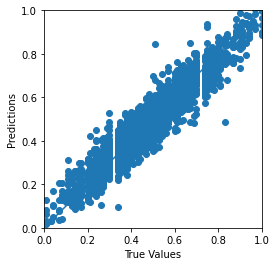

In [200]:
# Linear Regression

linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)
y_test_predict = linreg.predict(X_test)
print(mean_absolute_error(y_test, y_test_predict))
print(mean_squared_error(y_test, y_test_predict))
compare_values(y_test, y_test_predict)

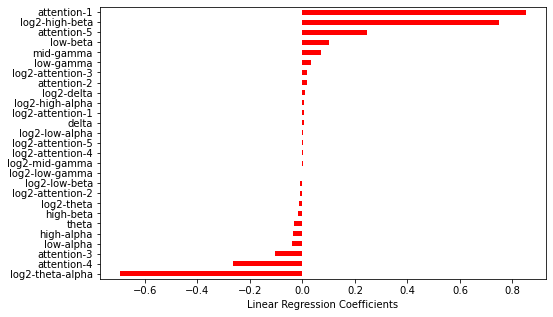

In [201]:
plot_features_weights('Linear Regression', linreg.coef_[0], df.columns[1:], 'c')

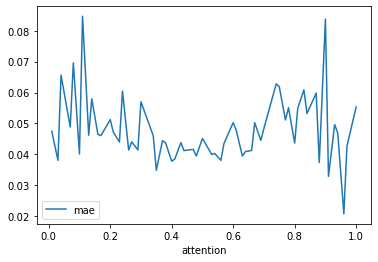

In [202]:
plot_error_vs_attention(y_test, y_test_predict)

0.05140391300594028
0.00421804547936517


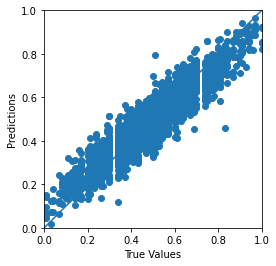

In [203]:
# LASSO

lasso = linear_model.Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
y_test_predict = lasso.predict(X_test)
print(mean_absolute_error(y_test, y_test_predict))
print(mean_squared_error(y_test, y_test_predict))
compare_values(y_test, y_test_predict)

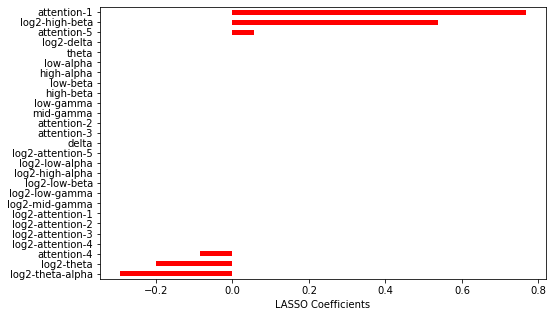

In [204]:
plot_features_weights('LASSO', lasso.coef_, df.columns[1:], 'c')

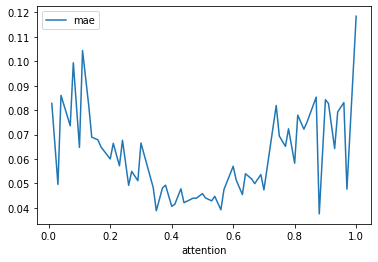

In [205]:
plot_error_vs_attention(y_test, y_test_predict)

0.04470848315152964
0.0032530977381738293


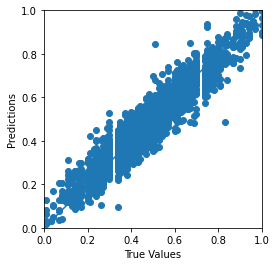

In [206]:
# Ridge

rdg = linear_model.Ridge(alpha=0.01)
rdg.fit(X_train, y_train)
y_test_predict = rdg.predict(X_test)
print(mean_absolute_error(y_test, y_test_predict))
print(mean_squared_error(y_test, y_test_predict))
compare_values(y_test, y_test_predict)

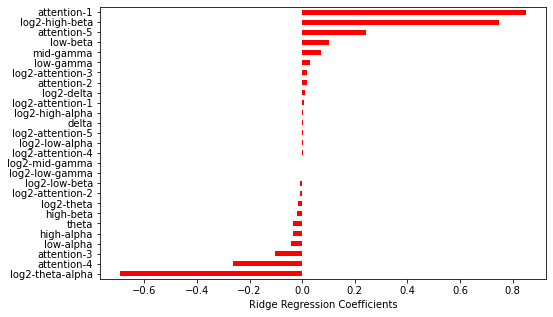

In [207]:
plot_features_weights('Ridge Regression', rdg.coef_[0], df.columns[1:], 'c')

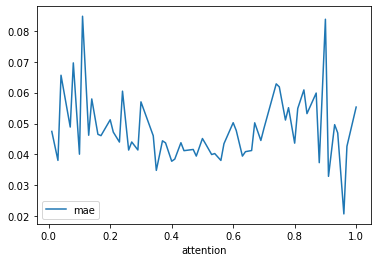

In [208]:
plot_error_vs_attention(y_test, y_test_predict)

0.046676910950779374
0.004814937701555047


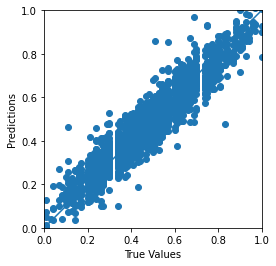

In [209]:
# Polynomial Regression

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
polyreg = linear_model.LinearRegression()
polyreg.fit(X_train_poly, y_train)
y_test_predict = polyreg.predict(X_test_poly)
print(mean_absolute_error(y_test, y_test_predict))
print(mean_squared_error(y_test, y_test_predict))
compare_values(y_test, y_test_predict)

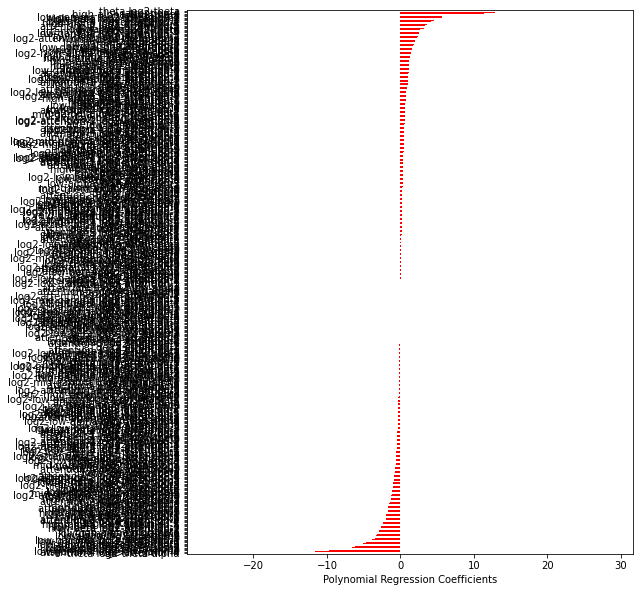

In [210]:
plot_features_weights('Polynomial Regression', polyreg.coef_[0], poly.get_feature_names(df.columns[1:]), 'c')

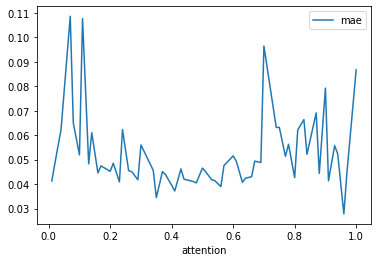

In [211]:
plot_error_vs_attention(y_test, y_test_predict)

0.07015236476666661
0.007863703808963092


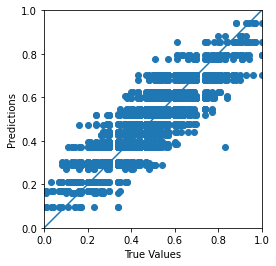

In [212]:
# Decision Tree regression

dtrg = DecisionTreeRegressor(max_depth=5)
dtrg.fit(X_train, y_train)
y_test_predict = dtrg.predict(X_test)
print(mean_absolute_error(y_test, y_test_predict))
print(mean_squared_error(y_test, y_test_predict))
compare_values(y_test, y_test_predict)

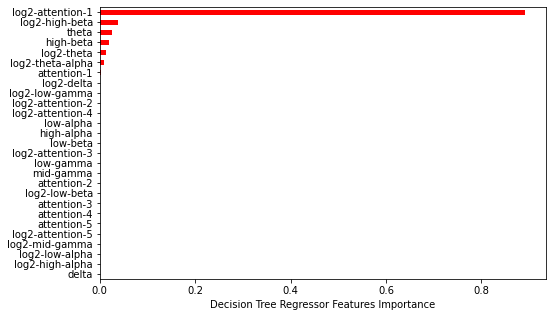

In [213]:
plot_features_weights('Decision Tree Regressor', dtrg.feature_importances_, df.columns[1:], 't')

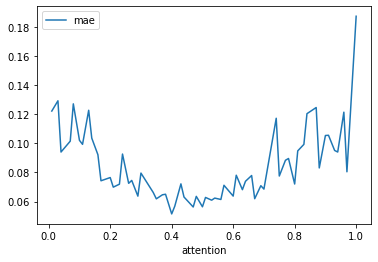

In [214]:
plot_error_vs_attention(y_test, y_test_predict)

0.06584144651804001
0.006833461219607199


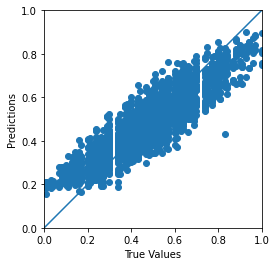

In [215]:
# Random Forest Regressor

rf = RandomForestRegressor(n_estimators=100, max_features=5, max_depth=6, n_jobs=-1, random_state=1)
rf.fit(X_train, np.ravel(y_train))
y_test_predict = rf.predict(X_test)
print(mean_absolute_error(y_test, y_test_predict))
print(mean_squared_error(y_test, y_test_predict))
compare_values(y_test, y_test_predict)

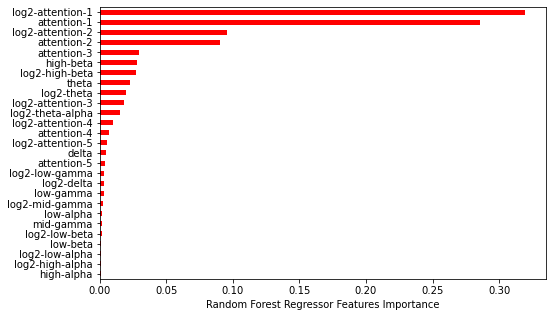

In [216]:
plot_features_weights('Random Forest Regressor', rf.feature_importances_, df.columns[1:], 't' )

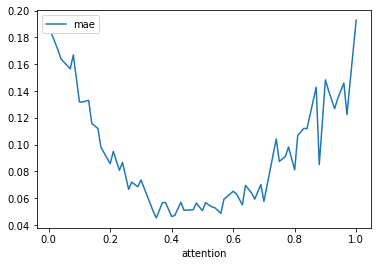

In [217]:
plot_error_vs_attention(y_test, y_test_predict)